# SpectrumLabs Data Science Interview Project - Aditya Tyagi

## Objective: Predict 4chan comment board membership
## Dataset: Obtained via 4chan API

## Organization:
- ### STEP 1: Extraction Cleaning
- ### STEP 2: Exploratory Analysis
- ### STEP 3: Disciminative Analysis
- ### STEP 4: Modelling



### We begin by importing necessary libraries.

In [447]:
import pandas as pd
import sklearn
import numpy as np
import requests
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import re
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.tokenize.treebank import TreebankWordDetokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.ensemble import RandomForestClassifier

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to C:\Users\Aditya
[nltk_data]     Tyagi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Aditya
[nltk_data]     Tyagi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Aditya
[nltk_data]     Tyagi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## The boards we will be analyzing are 'g', 'tv', 'ck', 'lit'. 
- g = "technology"
- tv = "tv/media"
- ck = "cooking"
- lit = "literature:


In [448]:
#list of boards
BOARDS = ['g', 'tv', 'ck', 'lit']
#how many threads to extract


API_ENDPOINT = "https://a.4cdn.org"


## STEP 1: Extraction/Cleaning 
## We define a few functions to acquire data from API.

get_threads() gets all the threads for a particular board.


get_comments() gets all the comments for a particular thread in a particular board.

In [449]:
#gets n pages worth of threads for board
def get_threads(board, n = 1):
    target = API_ENDPOINT + "/" + board.strip() + "/" + "threads.json"
    api_res = requests.get(target).json()
    curr_page = 0
    thread_list = []
    while (curr_page < n):
        [thread_list.append(thread) for thread in api_res[curr_page]['threads']]
        curr_page = curr_page + 1
    for thread in thread_list:
        thread['board'] = board
    
    return thread_list

#gets all the comments for a given board, threadID (incl. the root thread)
def get_comments(board, thread_id):
    target = API_ENDPOINT + "/" + board.strip() + "/" + "thread/" + str(thread_id) + ".json"
    try:
        api_res = requests.get(target)
    except:
        print("Error in contacting API endpoint! Either board or thread_id is bad!")
        return
    comments = api_res.json()['posts']
    comment_list = []
    for comment in comments:
        if 'com' in comment.keys():
            comment_id = comment['no']
            com = comment['com']
            time = comment['now']
            comment_obj = {"board": board, 'comment_id': comment_id, 'time': time, "content":com}
            comment_list.append(comment_obj)
    return comment_list


## We now ingest the data as a dataframe.

### Each row represents a comment. And the following columns are included:
- thread_id: the thread id of the thread that the comment is part of
- comment_id: the comment's id
- board: the board that the comment is part of
- time: the time of the comment
- content: the actual text of the comment


In [450]:
def create_dataframe():
    comments = []
    threads = []
    for board in BOARDS:
        for thread in get_threads(board):
            thread_id = thread['no']
            thread_comments = get_comments(board, thread_id)
            for comment in thread_comments:
                comments.append(comment)
                threads.append(thread)
    thread_ids = [thr['no'] for thr in threads]
    thread_boards = [thr['board'] for thr in threads]
    comment_ids = [comm['comment_id'] for comm in comments]
    boards = [comm['board'] for comm in comments]
    times = [comm['time'] for comm in comments]
    contents = [comm['content'] for comm in comments]
    df_dict = {'thread_id': thread_ids, 'comment_id': comment_ids, 
               'board': boards, 'time': times, 'content': contents}
    return pd.DataFrame.from_dict(df_dict)

Optionally, we can also persist the data to our local filesystem in the form of a .csv

In [451]:
dataset = create_dataframe()
dataset.to_csv('comments.csv',index = False)

### We can now read the data that we persisted as a pandas dataframe.  To ensure smooth running, I am using static comments data. To use the latest data that we just persisted above, replace 'comments-old.csv' in the below cell with 'comments.csv'.

In [435]:
dataset = pd.read_csv('comments-old.csv')
dataset.head()

,thread_id,comment_id,board,time,content
0,51971506,51971506,g,12/20/15(Sun)20:03:52,"The /g/ Wiki:<br><a href=""http://wiki.installg..."
1,75841871,75841871,g,05/10/20(Sun)11:15:55,are these unironically our/g/uys? <br>post ur ...
2,75841871,75841887,g,05/10/20(Sun)11:17:29,/ourguys/<br>XYZpilled<br>youtubers<br><br>are...
3,75837108,75837108,g,05/10/20(Sun)02:35:44,Welcome to the Daily Programming Thread: Small...
4,75837108,75837130,g,05/10/20(Sun)02:37:45,Can I compile Java14 to run on JVM8 ?


## STEP 2: Exporatory Analysis

### We obtain the following insights:
- comments per thread for each board
- common words for each board
- visualization of the distribution of replies per thread for each of board
- center, spread statistics for replies per thread for each board


But first we have to clean up the comment content. We do the following:
- remove HTML tags, punctuation
- remove numbers
- remove whitespace
- tokenize the comment
- remove stop words (stop words are overly common and add little discriminative value) (e.g. a, the, as, etc.)
- lemmatize the remaining words (lemmatization maps each word to its root, so running, ran, runs, etc. get mapped to run)



In [436]:
#returns preprocessed text as list of tokens 
def preprocess_string_nltk(s):
    #remove punctutation, spaces, numbers, html tags, etc.
    clean_s =  re.sub("<.*?>", "", s)
    clean_s = re.sub(r"[^\w\s]", "",clean_s)
    clean_s = re.sub(r'\d+','',clean_s)
    #lower case
    clean_s = clean_s.lower()
    #tokenize
    tokens = word_tokenize(clean_s)
    #remove stop words
    stop_words = stopwords.words('english')
    
    
    stop_removed = [w for w in tokens if w not in stop_words]
    #lemmatize the words
    lemmatizer = WordNetLemmatizer()
    lemmatized = [lemmatizer.lemmatize(w) for w in stop_removed]
    #return as a list
    return lemmatized

#returns preprocessed text as string
def preprocess_string_string(s):
    clean_s =  re.sub("<.*?>", "", s)
    clean_s = re.sub(r"[^\w\s]", "",clean_s)
    clean_s = re.sub(r'\d+','',clean_s)
    #lower case
    clean_s = clean_s.lower()
    #tokenize
    tokens = word_tokenize(clean_s)
    
    #remove stop words
    stop_words = stopwords.words('english')
    stop_removed = [w for w in tokens if w not in stop_words]
    #lemmatize the words
    lemmatizer = WordNetLemmatizer()
    lemmatized = [lemmatizer.lemmatize(w) for w in stop_removed]
    #untokenize the words and return as string 
    ret_string = TreebankWordDetokenizer().detokenize(lemmatized)
    return ret_string



    
    
print(preprocess_string_nltk('Hello World! My name is Adi. My favorite number is 108. Here is a cool link: \
                  <a href = https://google.com > Click here! </a>'))


print(preprocess_string_string("Hello World! My name is Adi. My favorite number is 108. \
                            Here is a cool link: <a href = https://google.com > Click here! </a>"))


['hello', 'world', 'name', 'adi', 'favorite', 'number', 'cool', 'link', 'click']
hello world name adi favorite number cool link click


Now we can calculate the mean number of replies per thread, median number of replies per thread, and sd of number of replies per thread.
We do the above for each of the boards.

In [437]:
for board in BOARDS:
    replies_per_thread = dataset[dataset['board'] == board][['thread_id' , 'comment_id']].groupby('thread_id').count()
    print("Mean Number of Replies per thread for " + board + ": " + str(replies_per_thread['comment_id'].mean()))
    print("Median Number of Replies per thread for " + board + ": " + str(replies_per_thread['comment_id'].median()))
    print("SD of Number of Replies per thread for " + board + ": " + str(replies_per_thread['comment_id'].std()))
    print("---------")

    

Mean Number of Replies per thread for g: 49.2
Median Number of Replies per thread for g: 15.0
SD of Number of Replies per thread for g: 67.49730153336291
---------
Mean Number of Replies per thread for tv: 72.6
Median Number of Replies per thread for tv: 50.0
SD of Number of Replies per thread for tv: 76.39072494185965
---------
Mean Number of Replies per thread for ck: 39.266666666666666
Median Number of Replies per thread for ck: 18.0
SD of Number of Replies per thread for ck: 53.91854526792729
---------
Mean Number of Replies per thread for lit: 27.666666666666668
Median Number of Replies per thread for lit: 17.0
SD of Number of Replies per thread for lit: 27.025561092805315
---------


From the above, we can see that for all boards, the mean and median are significantly different. In fact, the mean is always higher than the median. This signifies that the distribution is right skewed. I investigate further by visualizing the distributions.

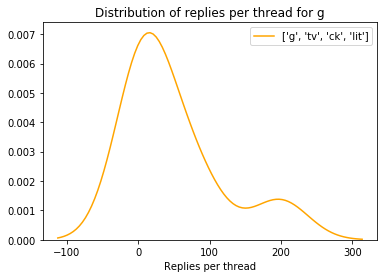

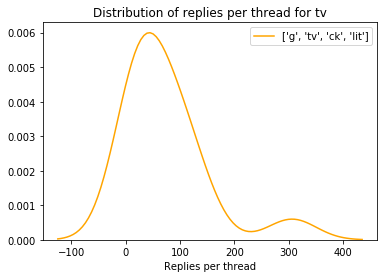

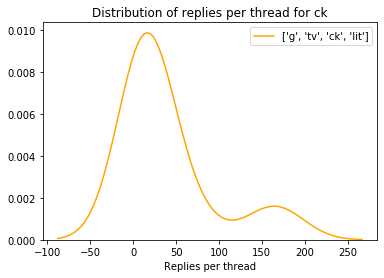

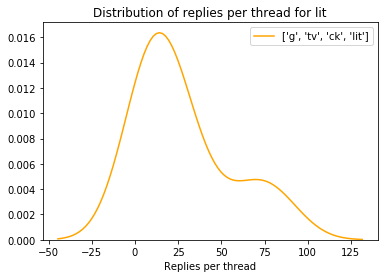

<Figure size 432x288 with 0 Axes>

In [438]:
for board in BOARDS:
    replies_per_thread = dataset[dataset['board'] == board][['thread_id' , 'comment_id']].groupby('thread_id').count()
    sns.distplot(replies_per_thread['comment_id'], axlabel= 'Replies per thread', label = BOARDS, hist = False, 
                 color = 'orange')
    plt.title("Distribution of replies per thread for " + board)
    plt.figure()

Our insight has been confirmed. The distributions are indeed right skewed. We could further quantify our results by calculating skewness, kurtosis (to measure tailedness) of the distribution. Furthermore, we can also rectify the skewness by log transformations, etc. but we leave that for another time (when we have more time).


For now, let's turn out attention to the common words for each board. We calculate the top n words for each board. You can change MAX_WORDS to increase/decrease the number of max words produced for each board. 

In [439]:
MAX_WORDS = 10
def flatten(l):
    flattened = []
    for word_list in l:
        for token in word_list:
            flattened.append(token)
    return flattened
    

#common words for each board
for board in BOARDS:
    filtered = dataset[dataset['board'] == board]
    cleaned = np.array(filtered['content'].apply(preprocess_string_nltk))
    token_list = flatten(cleaned)
    fd = FreqDist(token_list)
    print("Board: " + board)
    fd.tabulate(MAX_WORDS)
    print("-------")
    
    
    
    


Board: g
 like   get   one     x     b  dont   use    im would  shit 
   84    75    65    65    58    57    56    49    47    46 
-------
Board: tv
     like     movie       kid       one      even    people character      make      want     would 
      157        96        87        83        78        76        76        75        72        67 
-------
Board: ck
  like   dont animal    eat  would   meat  vegan   make   food    get 
    83     74     69     68     60     59     47     46     45     43 
-------
Board: lit
  like people   dont    get   book  would   time    one  youre  think 
    54     45     44     40     36     35     33     33     32     31 
-------


Our intuition is confirmed. Words like movie, people, character are common in /tv, while meat, vegan, food, etc. are common in /ck


Let's now have a look at the distrbution of board (the dep. variable) in our dataset. The distribution is not exactly balanced. With more time, we could use oversampling/undersampling techniques or SMOTE to generate artificial samples. 

In [440]:
#distribution of dep. variable (board)
dataset['board'].value_counts()/len(dataset)

tv     0.384670
g      0.260685
ck     0.208054
lit    0.146591
Name: board, dtype: float64

## STEP 3: Discriminative Analysis

Now let's turn our attention to identifying characteristic words for each of the boards. We use tfidf to do so. tfidf is a measure of how valuable a word/term is to a particular document. A higher tf-idf value indicates a more characteristic term for the document in question, and a lower tf-idf indicates a less characteristic word for the particular document. 

for a given (term, document) pair tfidf is the product of the term frequency (prop. of times it appears in the document) and the log(1/df), where the df is the proportion of documents the term appears in througout the corpus. It is easy to see that highly characteristic words appear often in a given document (high term freq.), while rarely in across throughout the corpus. (low inverse document freq.)

You can change TOP_N to get higher/lower number of words for a particular board. Since our common word analysis above showed that the word "like" appeared really often, let's drop that word from our analysis.

In [441]:
TOP_N = 10
#get characteristic words via tf-idf


#first create a text corpus for each boards
corpus = []
for board in BOARDS:
    filtered = dataset[dataset['board'] == board]
    rows = list(filtered.iterrows())
    text = ""
    for row in rows:
        clean_string = preprocess_string_string(row[1]['content'])
        #like appears way too often across all boards, so not really characteristic
        text = text + " , " + clean_string.replace("like", "")
    corpus.append(text)

#compute tfidf
tfidf = TfidfVectorizer()
tfidf_res = tfidf.fit_transform(corpus)
tfidf_df = pd.DataFrame(tfidf_res.todense().tolist(), columns = tfidf.get_feature_names())


#identify top characteristic words for each document (i.e. board)
for i in range(4):
    doc_tfidf = tfidf_df.iloc[i]
    sorted_tfidf = sorted(doc_tfidf.items(), key=lambda item: item[1], reverse = True)
    print("Board: " + BOARDS[i])
    print(sorted_tfidf[:TOP_N])
    print("------")
    


Board: g
[('get', 0.19466405687251823), ('headphone', 0.1840295778201562), ('one', 0.1687088492895158), ('cable', 0.16413448832608524), ('io', 0.14921317120553204), ('dont', 0.14794468322311385), ('use', 0.1453491624648136), ('im', 0.12718051715671191), ('would', 0.12198947564011142), ('shit', 0.11939395488181118)]
------
Board: tv
[('movie', 0.1829666748659283), ('character', 0.1771706525369006), ('kid', 0.16581354909724752), ('one', 0.1581899376445005), ('even', 0.14866042332856674), ('people', 0.14484861760219325), ('make', 0.1429427147390065), ('want', 0.13722500614944624), ('woman', 0.1282156038095991), ('get', 0.12769549183351248)]
------
Board: ck
[('eat', 0.28078157445923196), ('meat', 0.24361930725139244), ('animal', 0.23065977872552318), ('dont', 0.20224466308878636), ('vegan', 0.19406961764093972), ('food', 0.1858113360391976), ('would', 0.16398215926117812), ('make', 0.1257196554335699), ('chicago', 0.12045770526088113), ('pizza', 0.12045770526088113)]
------
Board: lit
[('

This time our results make more sense. Our approach has been successful. I have identified strongly characteristic words for each of our boards.


Now let's move our attention to modelling.


## STEP 4: Modelling

Respecting the time constraint, we shall use two different vectorizers:
- count-vectorizer: converts our text column to a matrix where each row represents a comment, and the columns are the terms in our corpus. each entry is the count of the number of times the term appears in the particular comment.
- tfidf-vectorizer: converts our text column to a matrix where each row represents a comment, and the columns are the terms in our corpus. each entry is the tfidf score of the particualr (comment, term) pair


Since the resulting bag-of-words matrix is quite large, we only accept terms that are in > 0.01 of all documents.
We finally have 176 terms in our matrix, and 2831 comments as before.

In [442]:
#generate modelling dataset
#use a simple count vectorizer
cvec = CountVectorizer(min_df = 0.01, max_df = 0.95)
cvec_res = cvec.fit_transform(dataset['content'].apply(preprocess_string_string))
cvec_df = pd.DataFrame(cvec_res.todense().tolist(), columns = cvec.get_feature_names()).join(dataset['board'])

cvec_res.shape

(2831, 176)

In [443]:
#use a simple tfidf vectorizer
tfidf = TfidfVectorizer(min_df = 0.01)
tfidf_res = tfidf.fit_transform(dataset['content'].apply(preprocess_string_string))
tfidf_df = pd.DataFrame(tfidf_res.todense().tolist(), columns = tfidf.get_feature_names()).join(dataset['board'])
tfidf_res.shape

(2831, 176)

To evaluate generalizability of our results, we split our dataset into separate train/test splits. Approx 70% of comments are randomly sampled into the train set, and 30% in the test set.

This is done for both vectorization formats.

In [444]:
#generate train, test split for cvec, and tfidf vectorizations
test_cvec = cvec_df.sample(frac = 0.3, random_state= 108)
train_cvec = cvec_df.drop(test_cvec.index)

test_tfidf = tfidf_df.sample(frac = 0.3, random_state = 108)
train_tfidf = tfidf_df.drop(test_tfidf.index)


I evaluate a simple Random Forest model for each of the vectorization formats. I chose Random Forest because it is a powerful ensemble technique that combines high predictive power for nonlinear relationships and variance reduction through the ensembling process. It also has a plenty of hyperparameters to tune. Also, it can be parallelized easily, thus ensuring quick train times.

In [445]:
rf_cvec = RandomForestClassifier()
rf_tfidf = RandomForestClassifier()
train_cvec_x = train_cvec.drop('board', axis = 1).to_numpy()
train_cvec_y = train_cvec['board'].to_numpy()
test_cvec_x  = test_cvec.drop('board', axis = 1).to_numpy()
test_cvec_y = test_cvec['board'].to_numpy()


train_tfidf_x = train_tfidf.drop('board', axis = 1).to_numpy()
train_tfidf_y = train_tfidf['board'].to_numpy()
test_tfidf_x = test_tfidf.drop('board', axis = 1).to_numpy()
test_tfidf_y = test_tfidf['board'].to_numpy()

rf_cvec.fit(train_cvec_x, train_cvec_y )
rf_tfidf.fit(train_tfidf_x, train_tfidf_y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Finally, let's compute our accuracy for each vectorization method. I chose accuracy as the evaluation metric because it is simple to understand and quick to compute. It is also easily understoood by nontechnical audiences. For more rigor, I would:
- compute a confusion matrix
- evaluate precision, recall, AUC for each of the boards
- compute an F1 score

In [446]:
def compute_accuracy(true, pred):
    return sum(true == pred)/len(true)

rf_cvec_pred = rf_cvec.predict(test_cvec_x)
rf_cvec_pred_train = rf_cvec.predict(train_cvec_x)

rf_tfidf_pred = rf_tfidf.predict(test_tfidf_x)
rf_tfidf_pred_train = rf_tfidf.predict(train_tfidf_x)


print("RANDOM FOREST TRAINING ACCURACY WITH COUNT VECTORIZATION: " + 
      str(compute_accuracy(train_cvec_y, rf_cvec_pred_train)))
print("RANDOM FOREST TEST ACCURACY WITH COUNT VECTORIZATION: " + str(compute_accuracy(test_cvec_y, rf_cvec_pred)))

print("-----------------")

print("RANDOM FOREST TRAIN ACCURACY WITH TFIDF VECTORIZATION: " + str(compute_accuracy(train_tfidf_y, rf_tfidf_pred_train)))
print("RANDOM FOREST TEST ACCURACY WITH TFIDF VECTORIZATION: " + str(compute_accuracy(test_tfidf_y, rf_tfidf_pred)))


RANDOM FOREST TRAINING ACCURACY WITH COUNT VECTORIZATION: 0.8168516649848637
RANDOM FOREST TEST ACCURACY WITH COUNT VECTORIZATION: 0.4617196702002356
-----------------
RANDOM FOREST TRAIN ACCURACY WITH TFIDF VECTORIZATION: 0.8153380423814329
RANDOM FOREST TEST ACCURACY WITH TFIDF VECTORIZATION: 0.4558303886925795


Not surprisingly, train accuracies are high (\~80%), but test accuracies are quite low (\~46%). This indicates severe overfitting. But this is to be expected: we are did not optimize our hyperparameters. With more time, I would carry out the following:
- use k-fold cross validation to select the best model rigorously
- explore a wider range of models (boosting, logistic regression, neural nets, linear/quadratic disciminative analysis, naive bayes, etc.)
- A comprehensive randomized grid search of the parameter space for the random forest model.

When it comes to productionalizing our model, our would setup the data pipeline using the following technologies that I know:
    - AWS S3, RDS, EC3
    - Docker containers
    - SQL Alchemy ORMs
    - Hadoop DFS, 
    - Map Reduce, Spark

### I hope you enjoyed my analysis! :) 